---
title: "Neuron Skeletons"
format: 
    html:
        toc: true 
        code-fold: false
jupyter: python3
---

## Download, visualize, and generate neuron skeletons

Created 7/2/2024 by Bethanny Danskin  
MICrONS Tutorial for VORTEX

Depends on the following two packages: [CAVEclient](https://caveconnectome.github.io/CAVEclient/) and [Skeleton-Plot](https://github.com/AllenInstitute/skeleton_plot) (version>0.0.9)

Skeletons and meshworks are loaded as [MeshParty meshwork object](https://meshparty.readthedocs.io/en/latest/)

[pcg-skel](https://github.com/CAVEconnectome/pcg_skel) and [cloudvolume](https://github.com/seung-lab/cloud-volume) are necessary if generating your own skeletons from the meshes

:::{important}
Using `CAVEclient` requires having set up a CAVE auth token. 
See [how to set up your CAVEclient token here](em_py_01_caveclient_setup.html).
:::

In [1]:
# !pip install caveclient
# !pip install skeleton-plot

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
from caveclient import CAVEclient
# Initialize a client for the "minnie65_public" datastack.
client = CAVEclient(datastack_name='minnie65_public') 

# see the available materialization versions
client.materialize.get_versions()

# Uncomment to get more details on each release version
# client.materialize.get_versions_metadata()

[1078, 117, 661, 343, 795, 943]

In [4]:
# set materialization version, for consistency
materialization = 1078 # current public as of 6/5/2024
# materialization = 661 # version at which skeletons were pre-generated
client.materialize.version = materialization

In [5]:
import skeleton_plot as skelplot
import skeleton_plot.skel_io as skel_io

### Set paths to the public repository

The skeletons of the meshes are calculated at specific timepoints. The last collection of all neurons in the dataset was at materialization version 661.

Both the .swc skeletons and .h5 meshwork objects are available in the [BossDB repository](https://bossdb.org/project/microns-minnie)

In [6]:
# path to the skeleton .swc files
skel_path = "s3://bossdb-open-data/iarpa_microns/minnie/minnie65/skeletons/v661/skeletons/"

# path to the skeleton and meshwork .h5 files
mesh_path = "s3://bossdb-open-data/iarpa_microns/minnie/minnie65/skeletons/v661/meshworks/"

### Example: load cell with known nucleus id and segment id

In [7]:
# Skeleton
nucleus_id = 292685
segment_id = 864691135122603047
skel_filename = f"{segment_id}_{nucleus_id}.swc"

# load the .swc skeleton
sk = skel_io.read_skeleton(skel_path, skel_filename)

In [8]:
# load the meshwork (may take minutes to locate, if using public credentials)
mesh_filename = f"{segment_id}_{nucleus_id}.h5"
mw = skel_io.load_mw(mesh_path, mesh_filename)

#### Plot skeleton

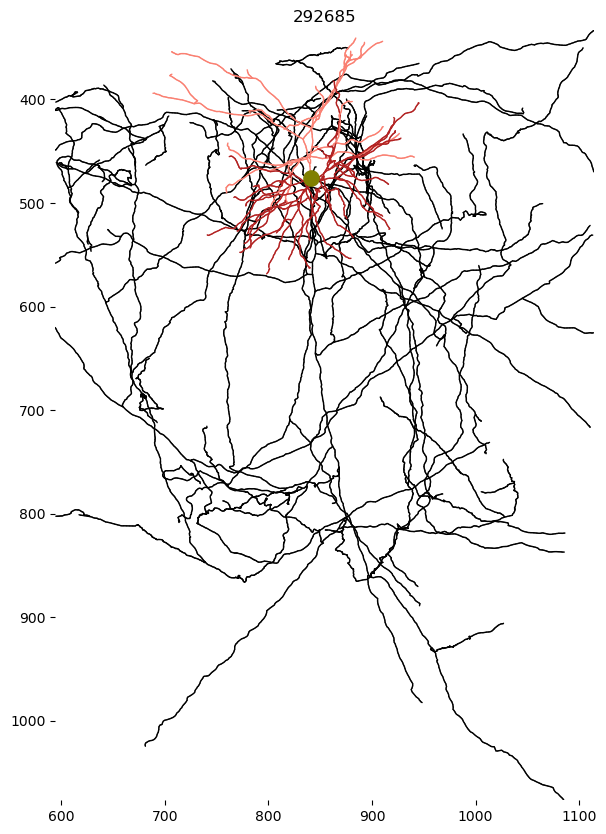

In [9]:
f, ax = plt.subplots(figsize=(7, 10))
skelplot.plot_tools.plot_skel(
    sk,
    title=nucleus_id,
    line_width=1,
    plot_soma=True,
    invert_y=True,
    pull_compartment_colors=True,
    x="z",
    y="y",
    skel_color_map = { 3: "firebrick",4: "salmon",2: "black",1: "olive" },
)

ax.spines['right'].set_visible(False) 
ax.spines['left'].set_visible(False) 
ax.spines['top'].set_visible(False) 
ax.spines['bottom'].set_visible(False)
# ax.axis('off')

#### Plot meshwork
The meshwork object (h5 file) includes additional information about the input and output synapse positions along the skeleton

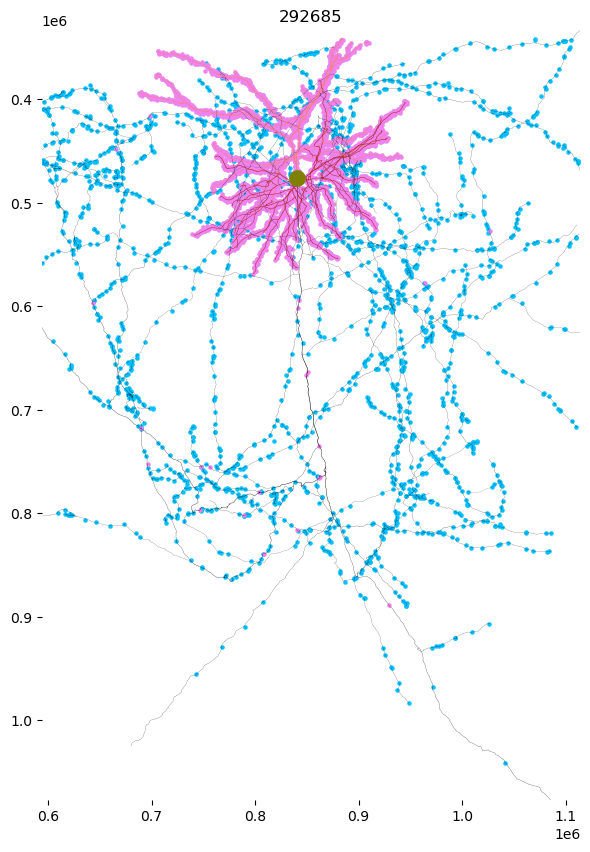

In [10]:
f, ax = plt.subplots(figsize=(7, 10))
skelplot.plot_tools.plot_mw_skel(
    mw, 
    title=nucleus_id,
    pull_radius = True,
    line_width=1,
    plot_soma=True,
    invert_y=True,
    pull_compartment_colors=True,
    x="z",
    y="y",
    skel_color_map = { 3: "firebrick",4: "salmon",2: "black",1: "olive" },
    plot_presyn = True,
    plot_postsyn = True,)

ax.spines['right'].set_visible(False) 
ax.spines['left'].set_visible(False) 
ax.spines['top'].set_visible(False) 
ax.spines['bottom'].set_visible(False)
# ax.axis('off')

### Example: load a neuron you have seen in neuroglancer

Let's say you have observed a cell in neuroglancer that you want to work with, like this pyramidal cell (https://neuroglancer.neuvue.io/?json_url=https://global.daf-apis.com/nglstate/api/v1/6320379988541440)

In [11]:
root_id_v1078 = 864691135356151759

The segment root_id may change with time, but the 6-digit nucleus id is much more static. Look up the nucleus id from the current root id

In [12]:
nuc_df = client.materialize.tables.nucleus_detection_v0(pt_root_id=root_id_v1078).query()
nucleus_id = nuc_df.id.item()
print(nucleus_id)

490689


Now use the nucleus id to look up the previous segmentation root id for v661 

(this is necessary to find the exact filename match. But alternately, you can use directory search to find the matching filenames with just the nucleus id)

In [13]:
segment_id = client.materialize.tables.nucleus_detection_v0(id=nucleus_id).query(
    materialization_version=661).pt_root_id.item()
segment_id

864691135851524807

In [14]:
# Load Skeleton
skel_filename = f"{segment_id}_{nucleus_id}.swc"

sk = skel_io.read_skeleton(skel_path, skel_filename)

#### Plot skeleton

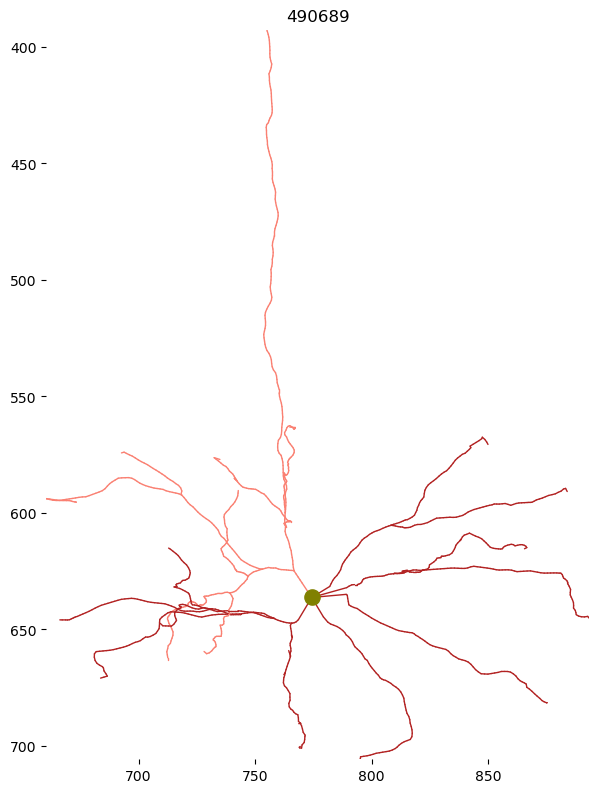

In [15]:
f, ax = plt.subplots(figsize=(7, 10))
skelplot.plot_tools.plot_skel(
    sk,
    title=nucleus_id,
    line_width=1,
    plot_soma=True,
    invert_y=True,
    pull_compartment_colors=True,
    x="z",
    y="y",
    skel_color_map = { 3: "firebrick",4: "salmon",2: "black",1: "olive" },
)

ax.spines['right'].set_visible(False) 
ax.spines['left'].set_visible(False) 
ax.spines['top'].set_visible(False) 
ax.spines['bottom'].set_visible(False)
# ax.axis('off')

Note that this skeleton has no axon compartment. That is because the axon has only been proofread after the skeleton was created. Non-proofread cells do not have their axon statistics generated.

### Example: querying the proofread cells

Cells that have undergone proofreading in the dataset are annotated in the `proofreading_status_and_strategy table`. For more information, [see the MICrONS-Explorer proofreading documentation](https://www.microns-explorer.org/manifests/mm3-proofreading)

In [16]:
# Load cells that have undergone proofreading
proof_df = client.materialize.tables.proofreading_status_and_strategy(status_axon=True).query(
    select_columns = ['pt_root_id','pt_position','status_dendrite','status_axon','strategy_dendrite','strategy_axon'],
    materialization_version=1078)

# This gives you the list of cells with axonal proofreading, anywhere in the dataset
proof_df.head()

Table Owner Notice on proofreading_status_and_strategy: NOTE: this table supercedes 'proofreading_status_public_release'. For more details, see: www.microns-explorer.org/manifests/mm3-proofreading.


,pt_root_id,status_dendrite,status_axon,strategy_dendrite,strategy_axon,pt_position
0,864691135617152361,t,t,dendrite_extended,axon_partially_extended,"[185152, 185344, 21255]"
1,864691136090326071,t,t,dendrite_extended,axon_fully_extended,"[192080, 190064, 22297]"
2,864691135082864887,t,t,dendrite_extended,axon_interareal,"[303659, 166262, 17349]"
3,864691136195284556,t,t,dendrite_extended,axon_fully_extended,"[173184, 217472, 21929]"
4,864691135565870679,t,t,dendrite_clean,axon_fully_extended,"[184384, 108896, 21755]"


**Note: for v661,** the current preferred proofreading table did not exist. Use `proofreading_status_public_release` instead

In [17]:
# Load cells that have underwent proofreading for v661
proof_df = client.materialize.tables.proofreading_status_public_release().query(
    select_columns = ['pt_root_id','pt_position','status_dendrite','status_axon'],
    materialization_version=661)

# This gives you the list of cells with axonal proofreading, anywhere in the dataset
proof_df.head()

Table Owner Notice on proofreading_status_public_release: NOTE: this table is deprecated and no longer receiving updates; please use 'proofreading_status_and_strategy' which is available in datastack version >= 1078 (datastack = minnie65_public or minnie65_phase3_v1).


,pt_root_id,status_dendrite,status_axon,pt_position
0,864691134884807418,extended,extended,"[299067, 123129, 22993]"
1,864691134885430010,extended,non,"[181280, 223040, 21399]"
2,864691134885645050,extended,non,"[172288, 222528, 21607]"
3,864691134918370314,clean,clean,"[170528, 226848, 20316]"
4,864691134918461194,clean,clean,"[189760, 127520, 20540]"


### Final example: generate skeletons with pcg_skel
This will let you create skeletons for more recently proofread cells that do not exist in the publicly pregenerated .swc files. However, these skeletons will come without apical dendrite labels 

[pcg-skel documentation](https://caveconnectome.github.io/pcg_skel/) 


In [18]:
# !pip install pcg-skel
# !pip install cloud-volume

In [19]:
import cloudvolume
import pcg_skel

# specify the materialization version
client.materialize.version = 1078

# initialize cloudvolume client
cv_minnie = cloudvolume.CloudVolume(client.info.segmentation_source(), use_https=True)

In [20]:
# pcg-skel pipeline code
input_id = 864691135639556411
id_is_nuc = False

# Cell identification meta
synapse_table = client.info.get_datastack_info()['synapse_table']
if id_is_nuc:
    id_col = 'id'
else:
    id_col = 'pt_root_id'
use_view = True
if use_view:
    row = client.materialize.query_view('nucleus_detection_lookup_v1', 
                filter_equal_dict = {id_col: input_id})
else:
    row = client.materialize.query_table('nucleus_detection_v0', 
                filter_equal_dict = {id_col: input_id})
    
    row = row.drop('created', axis = 1)

nuc_id = int(row['id']) 
root_id = int(row['pt_root_id'])
root_point = row['pt_position'].values[0]

print(f'starting on body {nuc_id}, {root_id}')

# create whole neuron with radius info
resample_spacing = 1510
collapse_soma = True
collapse_radius = 10_000
res = [4, 4, 40]
nrn =  pcg_skel.coord_space_meshwork(root_id,
                                     client=client,
                                     root_point=root_point,
                                     root_point_resolution=res,
                                     collapse_soma=collapse_soma,
                                     collapse_radius=collapse_radius,
                                     synapses='all',
                                     synapse_table=synapse_table,
                                     cv = cv_minnie)

# add radius properties df to annotations 
pcg_skel.features.add_volumetric_properties(nrn, client)
print('adding segment properties')
pcg_skel.features.add_segment_properties(nrn)
print('segment properties added')

starting on body 267207, 864691135639556411
adding segment properties
segment properties added


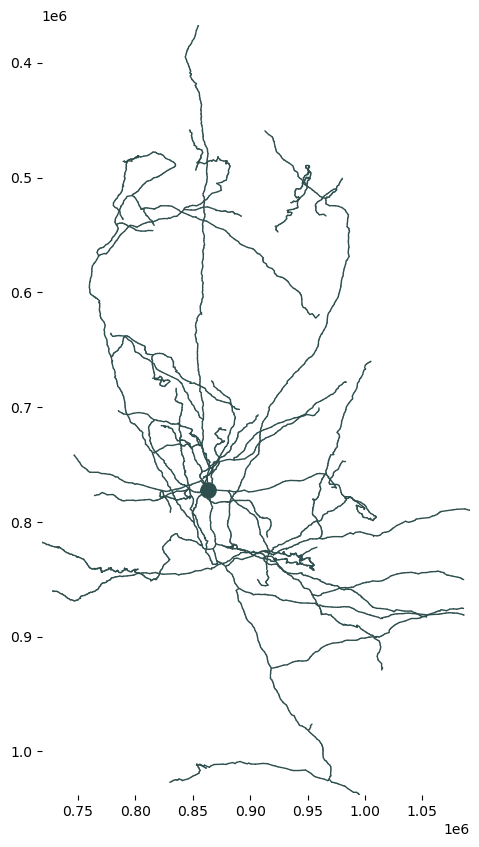

In [21]:
f, ax = plt.subplots(figsize=(7, 10))

skelplot.plot_tools.plot_verts(nrn.skeleton.vertices, 
                               nrn.skeleton.edges, 
                               nrn.skeleton.radius,
                               plot_soma=True,
                               soma_node=nrn.skeleton.root,
                               x="z",
                               y="y")

ax.spines['right'].set_visible(False) 
ax.spines['left'].set_visible(False) 
ax.spines['top'].set_visible(False) 
ax.spines['bottom'].set_visible(False)
plt.gca().invert_yaxis()

#### Save SWC file

In [22]:
# create compartment label
compartment_labels = np.zeros(len(nrn.skeleton.vertices)).astype(int)

# add soma label
compartment_labels[int(nrn.skeleton.root)]=1

# get the mesh volume properties
volume_df = nrn.anno.segment_properties.df

# add column indicating skel index 
volume_df['skel_index'] = nrn.anno.segment_properties.mesh_index.to_skel_index_padded
sk_volume_df = volume_df.drop_duplicates('skel_index').sort_values('skel_index').reset_index()

# set map for skel index -> radius
radius_labels = np.array(sk_volume_df['r_eff']) / 1000

# metadata dictionary for keeping vertex variables together
skeleton_properties = {}
skeleton_properties['compartment'] = compartment_labels
skeleton_properties['vertices'] = nrn.skeleton.vertices
skeleton_properties['edges'] = nrn.skeleton.edges
skeleton_properties['radius'] = radius_labels

In [23]:
nrn.skeleton.export_to_swc(filename = 'test.swc', 
                           node_labels=compartment_labels, 
                           radius=radius_labels,
                           avoid_root=True, 
                           resample_spacing = resample_spacing)

## Optional: generate myelin labels from myelin table
For the subset of neurons with manual labeling of myelination, see CAVE table and documentaiton for `vortex_manual_myelination_v0`

In [24]:
# Skeleton utility functions
from tqdm.notebook import tqdm, trange
tqdm.pandas()
def get_myelin_at_vertex(mw, myelin_df, properties_dict, client, cv):
    # given a df of all myelinated points on the axon, return the corresponding skeleton labels to the properties dictionary

    # get level2 nodes at myelinated positions
    myelin_lvl2 = myelin_df.progress_apply(pd_get_level2_point, axis=1, client=client, cv=cv)

    # generate index lookup
    mw_index_lookup = get_meshwork_index_lookup(mw)

    # merge myelin_lvl2 to index lookup
    myelin_merge = pd.merge(myelin_lvl2, mw_index_lookup, on='lvl2_id', how='inner')
    
    # empty myelin labels
    try:
        vertices = properties_dict['vertices']
    except:
        print('no vertex properties found; call get_skeleton_features_from_meshwork() first') 
        
    myelin = np.zeros(len(vertices))
    
    # where myelin is present, set to 1
    myelin[myelin_merge.skel_ind.values] = 1

    properties_dict['myelin'] = myelin

    return properties_dict

def pd_get_level2_point(row, client, cv, voxel_resolution=[4,4,40]):
    point, root_id = row[['pt_position','valid_id']]

    try:
        lvl2_id = pcg_skel.chunk_tools.get_closest_lvl2_chunk(point,
                                                              root_id,
                                                              client,
                                                              voxel_resolution=voxel_resolution,
                                                              radius=200)
        row['lvl2_id'] = lvl2_id
    except:
        row['lvl2_id'] = np.nan
        
    return row

def get_meshwork_index_lookup(mw):
    # generate index lookup with lvl2, mesh, and skeleton indices
    mw_index_lookup = mw.anno.lvl2_ids.df
    mw_index_lookup['skel_ind'] = mw.mesh_indices.to_skel_index_padded
    mw_index_lookup.set_index('mesh_ind_filt', inplace=True)

    return mw_index_lookup

In [25]:
# get myelin-labeled points (exists for a subset of manually annotated cells)
myelin_df = client.materialize.tables.vortex_manual_myelination_v0(valid_id=input_id, tag='t').query(
    select_columns=['valid_id','tag','pt_position'],
    materialization_version=1078,
)

print(len(myelin_df))

Table Owner Notice on vortex_manual_myelination_v0: Myelination status assessed for the axon of the VALID_ID, not the pt_root_id.


197


In [26]:
# Add myelin info (this takes upwards of 10 minutes to convert points to vertices)
skeleton_properties = get_myelin_at_vertex(nrn, myelin_df, skeleton_properties, client=client, cv=cv_minnie)

  0%|          | 0/197 [00:00<?, ?it/s]

In [27]:
print(skeleton_properties)

{'compartment': array([0, 0, 0, ..., 0, 0, 1]), 'vertices': array([[ 395328.,  547312.,  924200.],
       [ 396992.,  546184.,  923360.],
       [ 397712.,  545840.,  922760.],
       ...,
       [1313160.,  846424.,  797800.],
       [1314944.,  847008.,  792760.],
       [ 717824.,  771840.,  863120.]]), 'edges': array([[ 842,  866],
       [ 866,  867],
       [ 867,  868],
       ...,
       [4602, 4595],
       [4595, 4596],
       [4596, 4597]], dtype=int64), 'radius': array([0.12334736, 0.12334736, 0.12334736, ..., 0.13528796, 0.13528796,
       5.54981555]), 'myelin': array([0., 0., 0., ..., 0., 0., 0.])}


## Addendum: useful chunkedgraph functions (getting segments across time)

Because the segment id may have changed since the skeletons were calculated, find the past segment id of this object

Chunkedgraph [documentation](https://caveclient.readthedocs.io/en/latest/guide/chunkedgraph.html) and [functions](https://caveclient.readthedocs.io/en/latest/api/caveclient.html#caveclient.chunkedgraph.ChunkedGraphClientV1)

In [28]:
client.materialize.get_versions()

[1078, 117, 661, 343, 795, 943]

In [29]:
# Get info on version 661
client.materialize.get_versions_metadata()[2]

{'datastack': 'minnie65_public',
 'is_merged': False,
 'status': 'AVAILABLE',
 'version': 661,
 'id': 688,
 'valid': True,
 'time_stamp': datetime.datetime(2023, 4, 6, 20, 17, 9, 199182, tzinfo=datetime.timezone.utc),
 'expires_on': datetime.datetime(2125, 3, 27, 19, 17, 9, 199182, tzinfo=datetime.timezone.utc)}

In [30]:
timestamp_v661 = client.materialize.get_versions_metadata()[2]['time_stamp']
timestamp_latest = client.materialize.get_versions_metadata()[0]['time_stamp']

In [31]:
client.chunkedgraph.suggest_latest_roots(segment_id, timestamp=timestamp_latest)

864691135356151759

In [32]:
client.chunkedgraph.get_root_timestamps(root_id_v1078)

array([datetime.datetime(2024, 4, 10, 4, 7, 54, 947000, tzinfo=<UTC>)],
      dtype=object)

In [33]:
client.chunkedgraph.is_latest_roots(864691135808631069)

array([ True])